## Optimization Step 2-2
This script identifies exits with convenient access to substations. 

1. Filter exit locations with safe flood class 

2. Import geometry information of substations locations

3. Calculate the distance of each exit to its nearest substation

4. Save the updated exit dataset with distance information as a shp file 

<i>Yiwen Wang | 04/27/2020</i>

### Load exits and substation locations

In [1]:
import geopandas as gpd
from arcgis import GeoAccessor
from shapely.geometry import Point
import pandas as pd
from shapely.ops import nearest_points

/opt/conda/lib/python3.7/site-packages/arcgis/features/_data/geodataset/utils.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


In [2]:
#Import updated exits shape file with flood class as geodataframe 
exits_gdf = gpd.read_file('../Data/MJBA/exits_flood.shp')
exits_gdf.head()

,index,FID,Exit_ID,Longitude,Latitude,County,State,Highway,Type,AADT,Pop_dens,Comm_1mi,Ports_5mi,Ports_10mi,Ports_20mi,Close_nonT,Flood_Zone,geometry
0,0,7059,US-64_Cherokee_NC_Exit_1,-84.314304,35.019492,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.094152,Area of Minimal Flood Hazard,POINT (-84.31430 35.01949)
1,1,7060,US-64_Cherokee_NC_Exit_2,-84.311492,35.014933,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.365230,Area of Minimal Flood Hazard,POINT (-84.31149 35.01493)
2,2,7061,US-64_Cherokee_NC_Exit_3,-84.295528,35.013561,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,35.233979,Area of Minimal Flood Hazard,POINT (-84.29553 35.01356)
3,3,7062,US-64_Cherokee_NC_Exit_4,-84.280291,35.012880,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.048303,Area of Minimal Flood Hazard,POINT (-84.28029 35.01288)
4,4,7063,US-64_Cherokee_NC_Exit_5,-84.275190,35.017816,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.186597,Area of Minimal Flood Hazard,POINT (-84.27519 35.01782)


In [3]:
#Filter and plot the exits w/o flood risk 
safeexits_gdf = exits_gdf[exits_gdf["Flood_Zone"] =='Area of Minimal Flood Hazard']
safeexits_gdf.plot()

epsg:3857


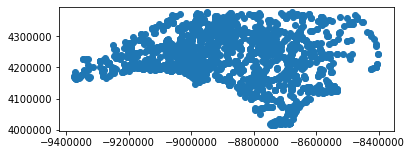

In [61]:
#Import datasets of exited chargers
substations = gpd.read_file('../Data/HIFLD/substations.shp')
substations.plot()
print(substations.crs)

In [62]:
#Transform the coordinate systems into 32617 with to_crs()
# crs = 4326 World Geodetic System 
# crs = 32617 UTM 17N

safeexits_gdf = exits_gdf.to_crs(32617)
substations = substations.to_crs(32617)

### Calculate distances between substations and exits

In [63]:
#Collapse all substations points into ONE multipoint with unary_union()
mp_substations = substations['geometry'].unary_union

In [64]:
#Define a function which finds the nearest substation for each safe exit and returns the distance 
def distance_to_substations(from_point,to_point):
    from_pt, to_pt = nearest_points(from_point, mp_substations) #nearest_points() returns a tuple
    distance = from_pt.distance(to_pt)
    return int(distance/1609.34)#convert km into mile

In [65]:
#Apply the funciton to each safe exit 
safeexits_gdf['Dist_to_substations']=safeexits_gdf['geometry'].apply(lambda x: distance_to_substations(x, mp_substations))
safeexits_gdf.head()

,index,FID,Exit_ID,Longitude,Latitude,County,State,Highway,Type,AADT,Pop_dens,Comm_1mi,Ports_5mi,Ports_10mi,Ports_20mi,Close_nonT,Flood_Zone,geometry,Dist_to_substations
0,0,7059,US-64_Cherokee_NC_Exit_1,-84.314304,35.019492,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.094152,Area of Minimal Flood Hazard,POINT (197578.012 3880227.389),5
1,1,7060,US-64_Cherokee_NC_Exit_2,-84.311492,35.014933,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.365230,Area of Minimal Flood Hazard,POINT (197817.907 3879713.054),5
2,2,7061,US-64_Cherokee_NC_Exit_3,-84.295528,35.013561,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,35.233979,Area of Minimal Flood Hazard,POINT (199270.172 3879512.464),5
3,3,7062,US-64_Cherokee_NC_Exit_4,-84.280291,35.012880,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.048303,Area of Minimal Flood Hazard,POINT (200658.638 3879391.092),4
4,4,7063,US-64_Cherokee_NC_Exit_5,-84.275190,35.017816,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.186597,Area of Minimal Flood Hazard,POINT (201142.266 3879923.503),3


In [66]:
#Save the updated safe exits dataframe into shp file 
safeexits_gdf.to_file('../Data/MJBA/Exits_distance_to_substations.shp')

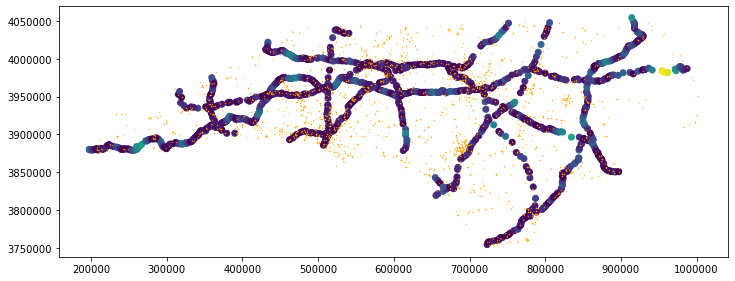

In [71]:
#Plot the safe exits with Dist_to_DFC as hue variation  
fig = safeexits_gdf.plot('Dist_to_substations',figsize=(12,6))

substations.plot(ax=fig,markersize=0.1,color='orange')